# SMAC Demo

**INSTALLATION NOTES**
  - SMAC seems to be incompatible with the latest version of numpy. Use numpy 1.26.4 instead `pip install numpy==1.26.4`
  - SMAC needs `swig` to be installed on your machine to be installable

This notebook demos dataset mixture tuning using SMAC3.
  - We have 8 datasets, each comprising 10,000 rows, from which we must select a 10,000-row training set
  - We use Bayesian Optimization to figure out the best number of rows to select from each of the 8 datasets to form our final 10,000-row training set

Some details
  - The datasets have two dependent variables (`X` and `Y`) and one independent variable (`Z`)
  - There are 8 datasets - `A`-`D` are the "good" ones, `E`-`H` are "bad" ones. Dataset `I` is a validation set. See `data_generation.py` for details on how they are generated.
  - For simplicity, the model we're training to predict `Z` based on `X` and `Y` is a random forest with a maximum tree depth of 6.
      * The `train` function below accepts a set of 8 weights $w_A$ through $w_H$ (between 0 and 100 - SMAC doesn’t seem to allow a constraint that forces parameters to sum to 1), normalizes them to sum to 1 as follows $w_i / \sum_j w_j$ (maybe use softmax in the future?), and then samples from each of the 8 datasets according to those proportions.
      * It then fits a random forest with trees of depth 6 to that sampled dataset and checks its performance on the validation set `I`.
      * The function also accepts a "budget" which is the number of trees in the forest. When we do this with a NN, this will be the computational budget/number of epochs/whatever
  - We then use SMAC3 to perform Bayesian optimization over these 8 weights. We use multi-fidelity optimization, which means that each combination of weights is first trained with a very low budget, bad combinations are quickly eliminated and only promising combinations of weights are trained further. Hyperband is used for this.

The plots at the bottom of the notebook show the progress of the optimizer.

**TO-DOs AND QUESTIONS**
  - Investigate the best way to optimize over weights that sum to 1
  - One way to do multi-fidelity optimization would be to start training all parameter combinations in parallel, and then *abort* any non-promising parameter combinations. As far as I can tell, SMAC doesn't have a mechanism to do this - instead, it begins by calling all parameter combinations with a low budget. It then looks at the results, picks the most promising combinations, and calls `train` again with a larger budget. The problem is that if `train` is implemented naively, it'll just "repeat" the lower-budget work every time it's called with a bigger budget (eg: if it's called with a budget of 5, it'll fit 5 trees, and then if it's fit with a budget of 8, it'll repeat the first 5 trees before building the next 3). In this code, I avoided this by saving all intermediate models in memory in a global variable. When the function is called again with the same parameters but a bigger budget, it tries to load the partially trained model before "continuing" to train it. For an NN, I imagine we'll have to save this to disk.
  - If you look at the plot tracing the cource of optimization, you will notice SMAC is running multiple rounds of Hyperband. I'm not sure this is optimal - a better approach might be to run a single round of Hyperband with many more starting combinations.
  - I'm confused by the way SMAC chooses new parameter combinations at the start of every Hyperband bracket. According to the paper, it's supposed to use a random forest trained on all high-budget runs that have completed, but it looks like it keeps on testing some very poor parameter combinations in later steps, so I want to investigate this further. I'm an hour or three into looking at the source code for the package to figure out what's going on - more to come hopefully.
  - I've tried to set seeds everywhere I could find them, but there still seems to be some randomness in this algo - it gives a different optimization path every time you run it. Hopefully I'll figure this out down the road.
  - There are a few things that the package/Hyperband *cannot* do that we might want to investigate
      * The only assumption it makes about the training process is that the loss will eventually converge to some final number as the budget goes to infinity. It doesn't make any assumptions about *how fast* that loss will decrease. If we can use some past scaling laws to put some prior on that convergence, we could abort "bad" parameter combinations far quicker
      * It makes zero parametric assumptions about the way our dataset weights affect the final loss (i.e., it uses a nonparametric model of the objective function). If our initial investigations seem to indicate there is some clear pattern, we might want to use something parametric here instead.

For all the reasons above, I'm wondering whether we should just forget about SMAC and implement this ourselves directly, but we can discuss.

In [1]:
import data_generation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.ensemble as sk_e
import sklearn.metrics as sk_m

import smac
import ConfigSpace

import pickle

### Generate synthetic data

In [2]:
data = data_generation.generate_data()

In [3]:
data.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

In [4]:
data['A'].head()

,X,Y,Z
0,-5.000000,0.0,338.354795
1,-4.924623,0.0,200.149925
2,-4.849246,0.0,265.039288
3,-4.773869,0.0,155.312166
4,-4.698492,0.0,379.934406


### Prepare training function

In [5]:
# Create a dictionary to store models in memory as they are trained; see
# doctstring for train() for an explanation. IRL, we'd need to save this
# to disk presumably
trained_models = {}

In [6]:
def train(config, seed, budget):
    '''
    This function takes a parameter combination from the SMAC3 optimizer, trains a
    model with it, and returns the model's performance from the validation set I.

    It accepts the following arguments:
      - config : a configuration object containing wA-wH, each numbers in [0, 100].
                 We normalize the numbers to sum to 1 to figure out the weight of
                 each dataset in our training sample
      - seed : the random seed to use
      - budget : the number of trees to use in the random forest. If this configuration
                 has been trained before with a lower budget, we retrieve that lower-
                 budget trained model from the trained_models dictionary and pick up
                 from where we left off to save time.
    '''

    # Normalize the wA-wH variables in our configuration
    # --------------------------------------------------
    weights = {i : config.get(f'w{i}') for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']}
    weights = {i : weights[i] / sum(weights.values()) for i in weights}

    # Check whether we already have a trained model
    # ---------------------------------------------
    serialized_config = str(sorted([f'{k}:{round(v, 5)}' for k, v in weights.items()]))
    global trained_models

    # Retrieve our previous trained model or create a new one and put it in the dict;
    # warm_start = True is needed to make sure we can pick up from where we left off next time
    # we use this model
    trained_models[serialized_config] = trained_models.get(serialized_config,
                                                           sk_e.RandomForestRegressor(n_estimators=0, random_state=seed, max_depth=6, warm_start=True))
    m = trained_models[serialized_config]
    
    # If the model has been trained before, we should only be seeing it again with a
    # higher budget (if the model was just created it'll have been created with a budget
    # of 0, so this will be true)
    assert int(budget) >= m.n_estimators
    
    # Set the budget
    m.n_estimators = int(budget)
    
    # Get the data we're training on
    # ------------------------------
    this_data = []
    for ds in weights:
        this_data.append(data[ds].sample(int(len(data[ds])*weights[ds]), random_state=seed))
    this_data = pd.concat(this_data)

    # Train
    # -----
    m.fit(X=this_data[['X', 'Y']], y=this_data['Z'])
    
    # Return the performance on the eval set (I)
    # ------------------------------------------
    return(sk_m.mean_squared_error(data['I']['Z'], m.predict(data['I'][['X', 'Y']])))

In [7]:
# Store the best and worse MSEs
best_mse  = train({'wA':1, 'wB':1, 'wC':1, 'wD':1, 'wE':0, 'wF':0, 'wG':0, 'wH':0}, seed=123, budget=30)
worst_mse = train({'wA':0, 'wB':0, 'wC':0, 'wD':0, 'wE':1, 'wF':1, 'wG':1, 'wH':1}, seed=123, budget=30)

# Clear the saved models
trained_models = {}

### SMAC

Create a configuration space, describing all the values, and the values they can take

In [8]:
cs = ConfigSpace.ConfigurationSpace()

for ds in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    cs.add_hyperparameter(ConfigSpace.Float(f'w{ds}', [0, 100]))
    
cs

Configuration space object:
  Hyperparameters:
    wA, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wB, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wC, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wD, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wE, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wF, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wG, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wH, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0

Create a scenario

In [9]:
scenario = smac.Scenario(cs,
                         walltime_limit = 30,
                         n_trials = 5000,
                         min_budget=1,
                         max_budget=30,
                         n_workers=1,
                         seed=123)

Use a hyperband intensifier. Train the random forests only on the highest budget runs

In [10]:
intensifier = smac.intensifier.hyperband.Hyperband(scenario, incumbent_selection='highest_budget', seed=123)

Create the optimizer

In [11]:
smac_instance = smac.MultiFidelityFacade(scenario,
                                         train,
                                         initial_design=smac.MultiFidelityFacade.get_initial_design(scenario),
                                         intensifier=intensifier,
                                         overwrite=True)

[INFO][abstract_initial_design.py:147] Using 80 initial design configurations and 0 additional configurations.


Optimize

In [12]:
out_params = smac_instance.optimize()

[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 1, and max budget 30.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [27, 9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [12, 4, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [6, 2]
[INFO][successive_halving.py:325] --- Bracket 3: [4]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [1.1111111111111112, 3.333333333333333, 10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 1: [3.333333333333333, 10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 2: [10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 3: [30.0]
[INFO][abstract_intensifier.py:515] Added config c4ab9d as new incumbent because there are no incumbents yet.
[INFO][smbo.py:319] Finished 50 trials.
[INFO][abstract_intensifier.py:594] Added config f1ca85 and rejected config c4ab9

### See how we did

In [13]:
print(smac_instance.validate(cs.get_default_configuration()))
cs.get_default_configuration()

382603.15235905076


Configuration(values={
  'wA': 50.0,
  'wB': 50.0,
  'wC': 50.0,
  'wD': 50.0,
  'wE': 50.0,
  'wF': 50.0,
  'wG': 50.0,
  'wH': 50.0,
})

In [14]:
print(smac_instance.validate(out_params))
out_params

16662.47074847869


/opt/homebrew/anaconda3/envs/recipes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Configuration(values={
  'wA': 72.47669723412127,
  'wB': 84.47327115053692,
  'wC': 58.94639556957109,
  'wD': 98.79014544394981,
  'wE': 0.6674720401110872,
  'wF': 0.10883664239609778,
  'wG': 0.7435000954277745,
  'wH': 3.248651718208093,
})

## Visualizations

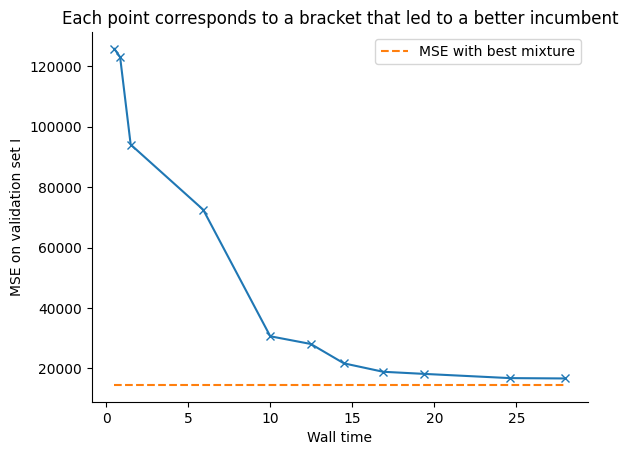

In [15]:
x = []
y = []
for t in smac_instance.intensifier.trajectory:
    x.append(t.walltime)
    y.append(t.costs[0])

plt.plot(x, y, 'x-')

baseline, = plt.plot([min(x), max(x)], [best_mse, best_mse], linestyle='--')

plt.legend([baseline], ['MSE with best mixture'])

plt.xlabel('Wall time')
plt.ylabel('MSE on validation set I')
plt.title('Each point corresponds to a bracket that led to a better incumbent')

sns.despine()

Display each bracket

SHOWING RUN 1


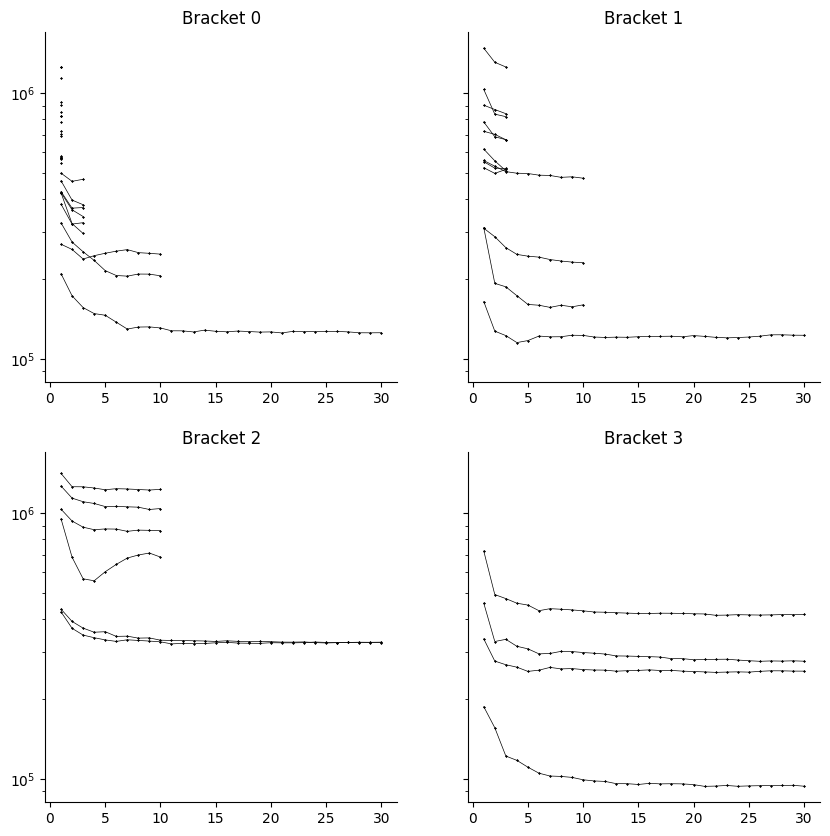

SHOWING RUN 2


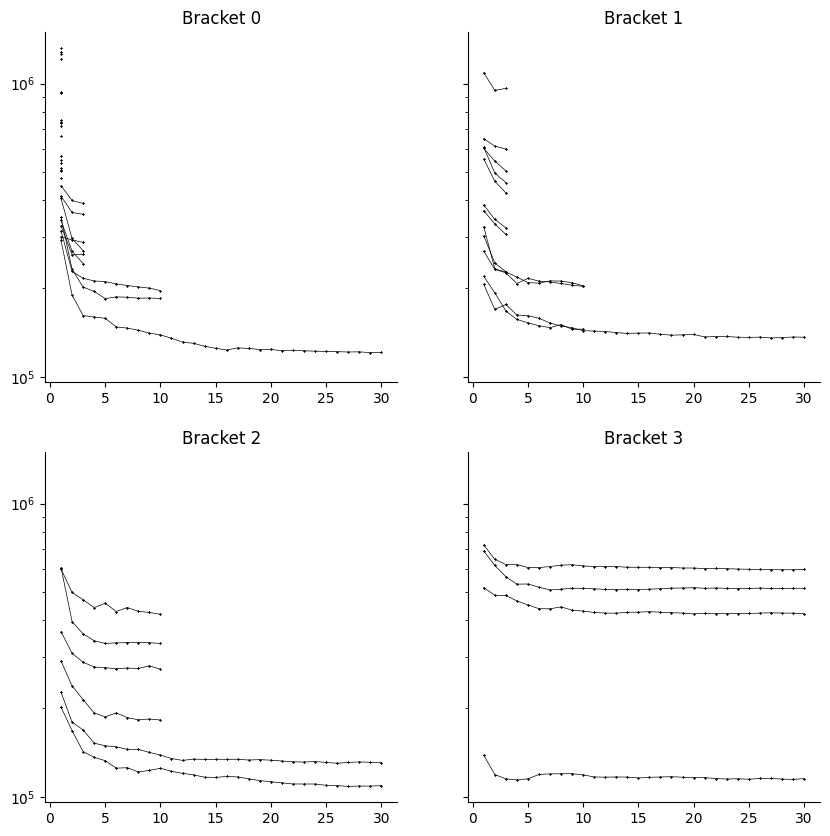

SHOWING RUN 3


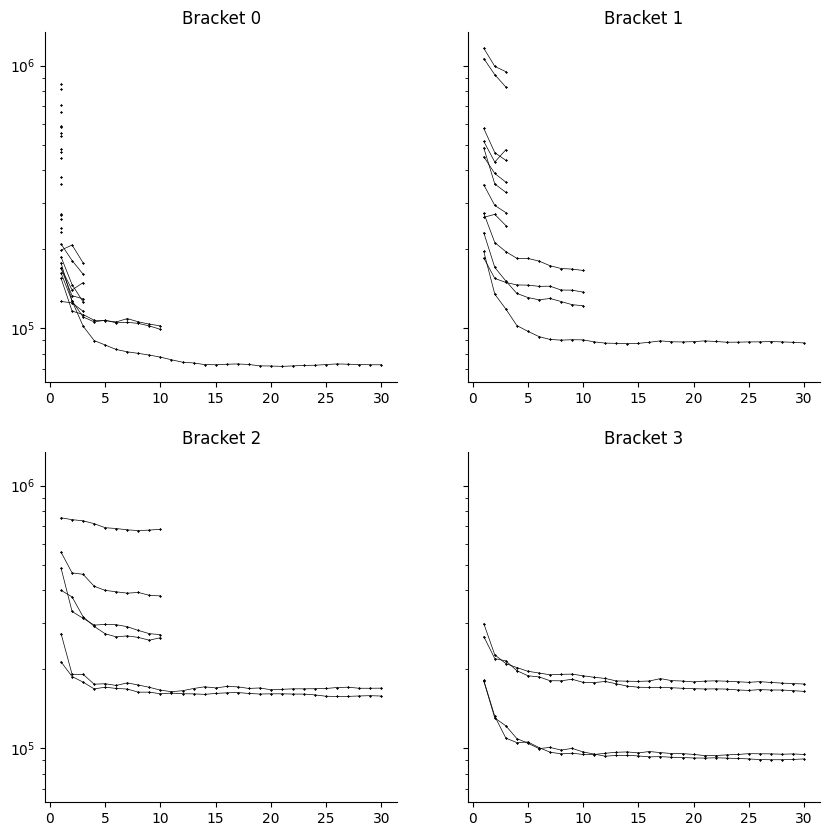

SHOWING RUN 4


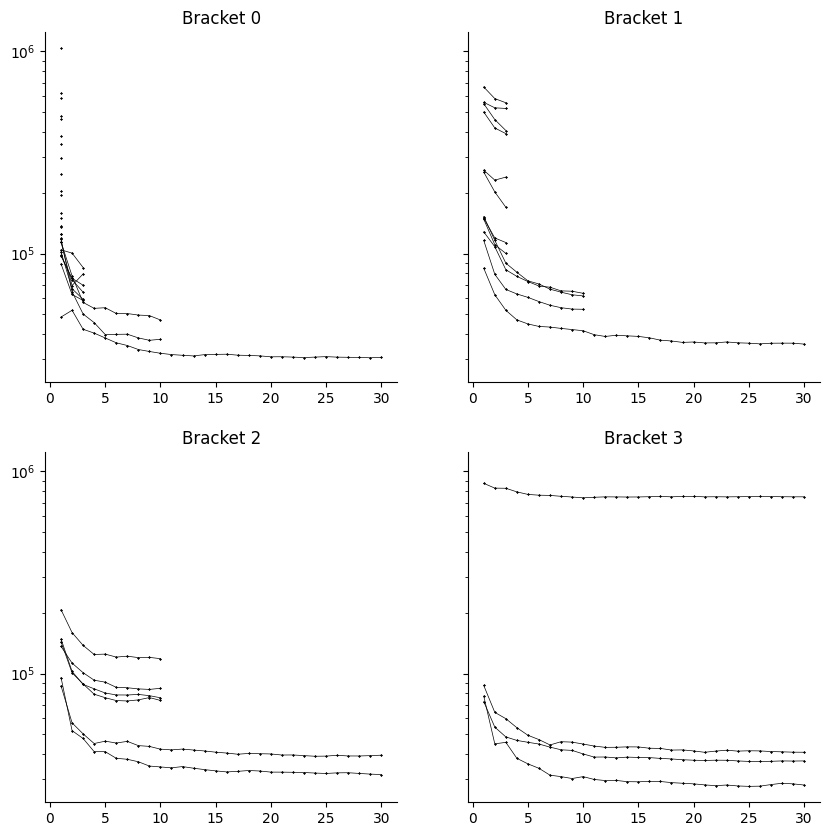

SHOWING RUN 5


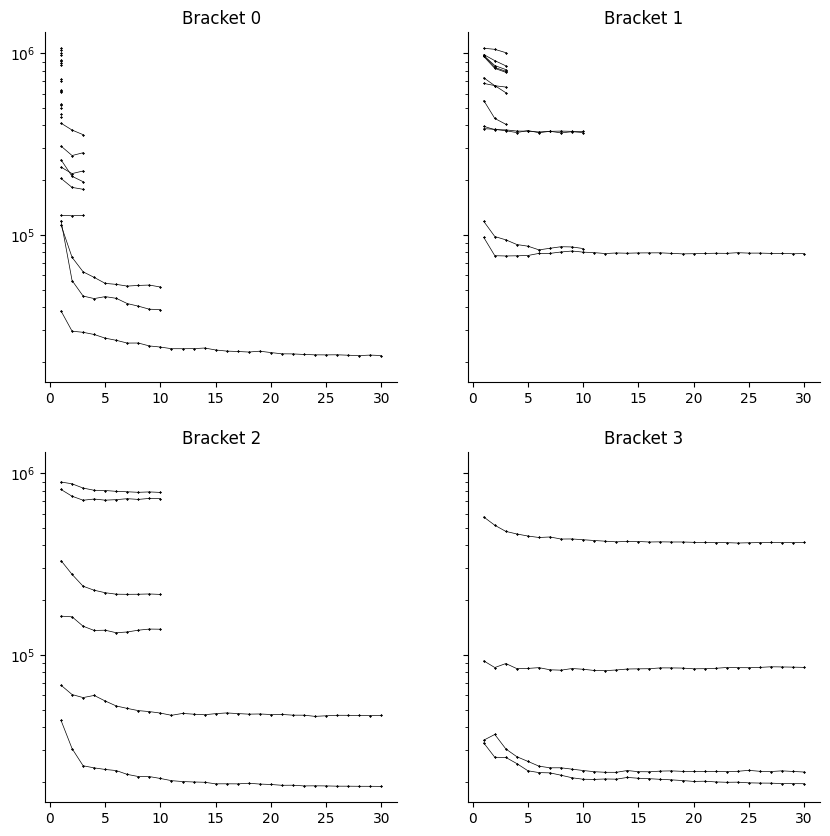

SHOWING RUN 6


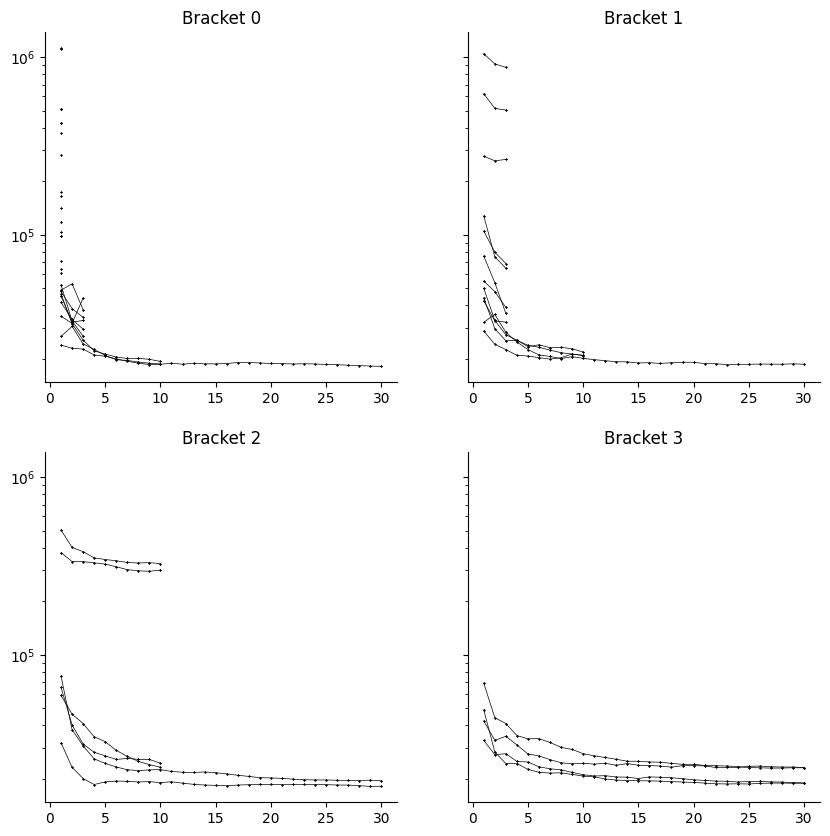

SHOWING RUN 7


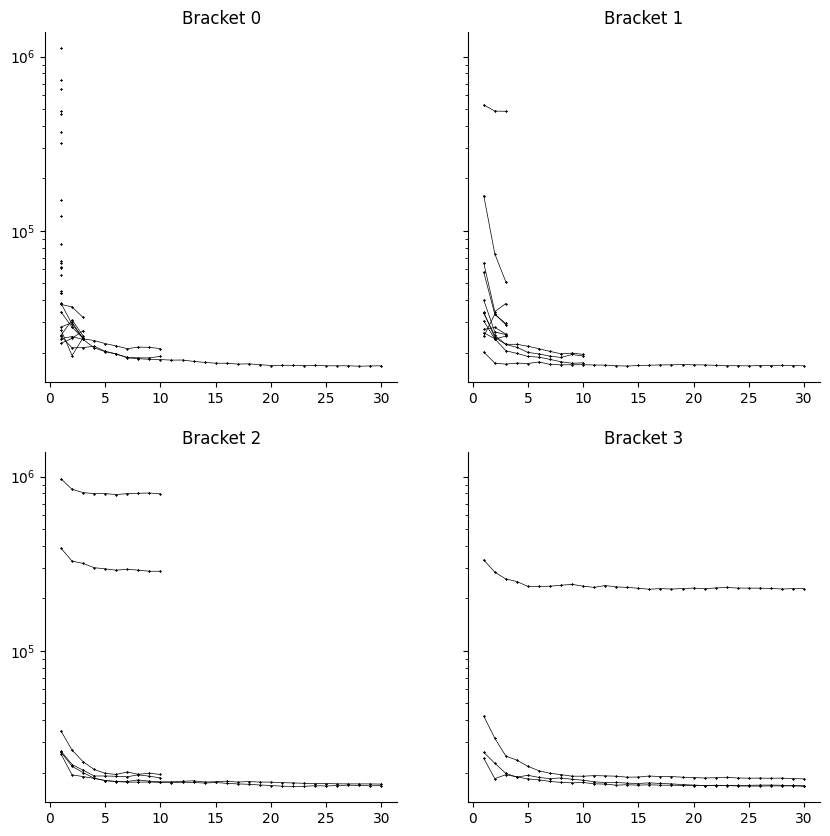

SHOWING RUN 8


In [16]:
def show_run(run_id):
    print(f'SHOWING RUN {run_id}')

    # Get the bracket configurations, and the total number of configurations
    # in each run
    bracket_sizes = intensifier._n_configs_in_stage
    configs_per_run = sum([sum(v) for k, v in bracket_sizes.items()])

    # Get all the configurations for this run
    if len(list(smac_instance.runhistory)) < configs_per_run*run_id:
        return False
    
    run_history = [smac_instance.runhistory.get_config(t.config_id)
                        for t in list(smac_instance.runhistory)[configs_per_run*(run_id-1):][:configs_per_run]]

    # Create  axes
    rows = int(np.ceil(len(bracket_sizes)/2))
    fig, ax = plt.subplots(rows, 2, figsize=(5*rows, 10), sharey=True)

    # For each bracket, the first configurations are the unique ones (the rest are
    # just extending the budget). Find those configurations for each budget
    bracket_configs = {}
    cur_config = 0
    for bracket_n in range(len(bracket_sizes)):
        bracket_configs[bracket_n] = run_history[cur_config:(cur_config+bracket_sizes[bracket_n][0])]
        cur_config += sum(bracket_sizes[bracket_n])

    # Plot the brackets
    for bracket, axis in zip(bracket_configs, ax.flatten()):
        for config in bracket_configs[bracket]:
            weights = {i : config.get(f'w{i}') for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']}
            weights = {i : weights[i] / sum(weights.values()) for i in weights}
            m = trained_models[str(sorted([f'{k}:{round(v, 5)}' for k, v in weights.items()]))]

            preds = np.vstack([e.predict(data['I'][['X', 'Y']].values) for e in m.estimators_])
            preds = np.cumsum(preds, axis=0) / np.arange(1, preds.shape[0] + 1)[:, None]
            errs = [sk_m.mean_squared_error(data['I']['Z'], p) for p in preds]

            axis.plot([i + 1 for i in range(len(errs))], errs, marker='x', markersize=1, linestyle='-', linewidth=0.5, color='black')
        
        axis.set_title(f'Bracket {bracket}')

        axis.semilogy()
        sns.despine()
    
    plt.show()

    return True

run_id = 1
while show_run(run_id):
    run_id += 1